In [9]:
import pandas
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle
import random
import joblib

In [22]:
norm = joblib.load('norm.pkl')
norm = norm[0]

In [31]:
rf = joblib.load('random_forest_model.pkl')
rf = rf[0]

In [23]:
# sourcer: https://nicolasfauchereau.github.io/climatecode/posts/drawing-a-gauge-with-matplotlib/

def convert(aCustomer: pandas.DataFrame):
  customer = aCustomer.copy()
  cols = ['account_check_status', 'credit_history', 'savings',
    'present_emp_since', 'installment_as_income_perc', 'other_debtors',
    'property', 'other_installment_plans', 'housing', 'credits_this_bank',
    'job', 'telephone', 'foreign_worker', 'estado_civil',
    'rango_plazos_credito', 'rango_edad'
  ]
  import json
  # Cargar los valores desde el archivo JSON
  with open('dictionaries.json', 'r') as json_file:
      dictionaries = json.load(json_file)
  for item in dictionaries: 
    column = item['column_name'] #Itera sobre cada columna del diccionario
    new_values = item['values'] #Obtiene el nombre de la columna del diccionario actual y lo almacena en la variable
    customer[column] = customer[column].map(new_values) #La función .map de pandas aplica el mapeo
  sex_mapping = {1: 0,  2: 1,  3: 0,  4: 0,  5: 1}
  customer['sexo'] = customer['personal_status_sex'].map(sex_mapping)
  civil_mapping = {1: 0, 2: 0, 3: 1, 4: 0, 5: 1}
  customer['estado_civil']= customer['personal_status_sex'].map(civil_mapping)
  customer['rango_edad'] = pandas.cut(x = customer['age'], bins=[18, 30, 40, 50, 60, 80], labels = [1, 2, 3, 4, 5])
  customer['rango_plazos_credito'] = pandas.cut(x = customer['duration_in_month'], bins=[1,12,24,36,48,72], labels = [1,2,3,4,5])
  columnas_a_eliminar = ['personal_status_sex', 'credit_amount', 'purpose', 'present_res_since', 'people_under_maintenance',  'age', 'duration_in_month', 'sexo', 'credit_amount']
  customer = customer.drop(columns=columnas_a_eliminar, axis=1)
  customer = customer.astype({'installment_as_income_perc': 'int64', 'credits_this_bank': 'int64'})
  customer_normalized = norm.transform(customer[cols])  
  return customer_normalized

def set_arrow(prob: float) -> int:   
  if (prob >= 75):
    arrow = 1
  elif (prob < 75) & (prob >= 50):
    arrow = 2
  elif (prob < 50) & (prob >= 25):
    arrow = 3
  else:
    arrow = 4
  return arrow

def degree_range(n): 
  start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
  end = np.linspace(0,180,n+1, endpoint=True)[1::]
  mid_points = start + ((end-start)/2.)
  return np.c_[start, end], mid_points

def rot_text(ang): 
  rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
  return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','VERY HIGH','EXTREME'], colors='jet_r', arrow=1, title='', fname=False): 

  N = len(labels)
  
  if arrow > N: 
      raise Exception("\n\nThe category ({}) is greated than \
      the length\nof the labels ({})".format(arrow, N))
  
  if isinstance(colors, str):
      cmap = cm.get_cmap(colors, N)
      cmap = cmap(np.arange(N))
      colors = cmap[::-1,:].tolist()
  if isinstance(colors, list): 
      if len(colors) == N:
          colors = colors[::-1]
      else: 
          raise Exception("\n\nnumber of colors {} not equal \
          to number of categories{}\n".format(len(colors), N))

  
  fig, ax = plt.subplots()

  ang_range, mid_points = degree_range(N)

  labels = labels[::-1]

  patches = []
  for ang, c in zip(ang_range, colors): 
      # sectors
      patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
      # arcs
      patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
  
  [ax.add_patch(p) for p in patches]


  for mid, lab in zip(mid_points, labels): 

      ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
          horizontalalignment='center', verticalalignment='center', fontsize=14, \
          fontweight='bold', rotation = rot_text(mid))

  r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
  ax.add_patch(r)
  
  ax.text(0, -0.08, title, horizontalalignment='center', \
        verticalalignment='center', fontsize=22, fontweight='bold')

  pos = mid_points[abs(arrow - N)]
  
  ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
  
  ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
  ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))
  
  ax.set_frame_on(False)
  ax.axes.set_xticks([])
  ax.axes.set_yticks([])
  ax.axis('equal')
  plt.tight_layout()
  if fname:
    fig.savefig(fname, dpi=200)

In [33]:
df_banco = pandas.read_csv('german_credit.csv')
# customer_id = random.randint(1, df_banco.shape[0])
customer_id = 25
customer = df_banco.iloc[customer_id].drop('default')
customer

account_check_status                                             < 0 DM
duration_in_month                                                     6
credit_history                 existing credits paid back duly till now
purpose                                                radio/television
credit_amount                                                      1374
savings                                                    ... < 100 DM
present_emp_since                                    1 <= ... < 4 years
installment_as_income_perc                                            1
personal_status_sex                                       male : single
other_debtors                                                      none
present_res_since                                                     2
property                                                    real estate
age                                                                  36
other_installment_plans                                         

La probabilidad de que no pague es de:  15.0
La probabilidad de que pague es de:  85.0


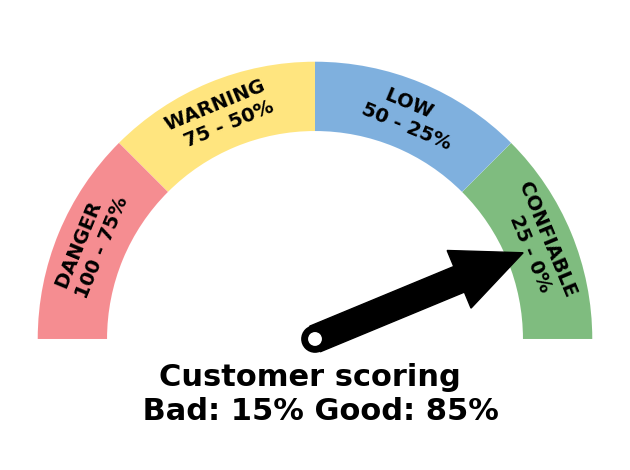

In [34]:
customer = convert(pandas.DataFrame(customer).T)

proba = rf.predict_proba(customer)*100
bad = proba[0][1]
good = proba[0][0]
print('La probabilidad de que no pague es de: ', bad)
print('La probabilidad de que pague es de: ', good)

arrow_value = set_arrow(bad)

gauge(labels=['DANGER \n 100 - 75%','WARNING \n 75 - 50%','LOW \n 50 - 25%', 'CONFIABLE \n 25 - 0%'], \
      colors=['#ED1C24','#FFCC00','#0063BF','#007A00'], arrow=arrow_value, title=f'Customer scoring \n Bad: {bad:.0f}% Good: {good:.0f}%') 